# Clasificación de imágenes

Este es un ejercicio de clasificación de imágenes por medio de redes neurolanes. Para ello, se utiliza el conjunto de imágenes <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/faces-mld/faces.tar.Z"> face.tar.Z </a>. Esta carpeta contiene 20 subcarpetas, cada una correspondiente a una persona diferente, y dentro de las cuales se encuentran un conjunto de fotos de la persona correspondiente, cada una representando diferentes patrones faciales. El patrón correspondiente que se presenta en la foto aparece etiquetado en el nombre de la imagen. Así, por ejemplo, an2i_left_angry_sunglasses.pgm corresponde a una foto en formato pgm de una persona mostrando su perfil izquierdo, mostrando una expresión facial de enojo y usa gafas.

Para el ejercicio, se decidió programar una red neuronal para determinar si en una foto concreta, la persona usa gafas, o no.

In [1]:
# Importación de librerías

import os                           # Para interactuar con el sistema interactivo
import numpy as np                  # Para manejo de matrices y vectores
# from skimage import io, transform

import matplotlib.pyplot as plt     # Para graficar
# import matplotlib.image as mpimg

# Funciones de deep learning para programar la red neuronal
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision import transforms, utils
import torchvision.models as models
import torch.optim as optim
from torchvision.utils import make_grid
import torch.nn.functional as F

# Para importar imágenes
import cv2

# Importación de scripts externos
from Net import *        # red neuronal
from imshow import *     # graficador de imágenes pre procesadas

Antes del procesamiento de las imágenes hay que tener en cuenta dos cosas. Primero, la librería `PIL` que es utilizada por `Pytorch` tiene una restricción respecto al tamaño de las imágenes que acepta para la importación de imágenes, por lo que antes es importante reducir el número de pixeles antes de procesar las imágenes. Segundo, dado que se pretende clasificar las imágenes según si la persona usa, o no, gafas, es necesario asignar en la carpeta de trabajo las imágenes a unas carpetas según la etiqueta de tener, o no, gafas (de acuerdo con el nombre de cada imagen). Para esto, si la imagen contiene la palabra "sunglasses" dentro de su nombre, es asignada a una carpeta, y de lo contrario, será asignada a otra carpeta.

Adicionalmente, hay que tener en cuenta que en principio hay 20 carpetas con imágenes; por lo que estas hay que repartirlas entre un grupo de entrenamiento y uno de evaluación. En este ejercicio se asigna un 70% al primer conjunto. Así, se crea una carpeta con el nombre "train" en la que se encuentran dos carpetas, una para fotos de personas con gafas y otra para las fotos de personas sin gafas. Lo mismo se hace con una carpeta que se llama "test" en la que se encontrará el 30% de las imágenes para evaluación.

In [2]:
folder = os.listdir('faces') # se accede al listado de carpetas
folder

['tammo',
 'choon',
 'kawamura',
 'bpm',
 'mitchell',
 'phoebe',
 'sz24',
 'night',
 'cheyer',
 'ch4f',
 'megak',
 'steffi',
 'at33',
 'karyadi',
 'kk49',
 'saavik',
 'boland',
 'danieln',
 'an2i',
 'glickman']

In [3]:
# Programa para asignar imágenes de entrenamiento y evaluación a sus respectivas carpetas

if not os.path.exists('datos'):

    os.mkdir('datos') # crear carpeta de datos
    os.mkdir('datos/train') # crear carpeta de entrenamiento
    os.mkdir('datos/test') # crear carpeta de evaluación
    
    os.mkdir('datos/test/sunglasses') # crear carpeta para fotos de evaluación de personas con gafas
    os.mkdir('datos/test/not_sunglasses') # crear carpeta para fotos de evaluación de personas sin gafas
    
    os.mkdir('datos/train/sunglasses') # crear carpeta para fotos de evaluación de personas con gafas
    os.mkdir('datos/train/not_sunglasses') # crear carpeta para fotos de evaluación de personas sin gafas
    
    # programa de asignación de imágenes
    i = 0
    for j in folder:
        i += 1
        folder_2 = os.listdir('faces/' + j) # listado de imágenes en la carpeta

        for k in folder_2:           
            img_path = 'faces/' + j + '/' + k # ruta de almacenamiento de la imagen
            img = cv2.imread(img_path) # se lee la imagen
            img = np.full(img.shape, img,dtype=np.float32) # reducción de pixeles
            
            
            if i <= 14: # condicional para el 70% para entrenamiento 
                if 'sunglasses' in k:
                    new_img_path = 'datos/train/sunglasses/' + k # nueva ruta para la imagen
                else:
                    new_img_path = 'datos/train/not_sunglasses/'+ k # nueva ruta para la imagen
                
            else: # condicional para el 30% para evaluar
                if 'sunglasses' in k:
                    new_img_path = 'datos/test/sunglasses/' + k # nueva ruta para la imagen
                else:
                    new_img_path = 'datos/test/not_sunglasses/' + k # nueva ruta para la imagen


            # Cambiar extensiones a .jpeg
            new_img_path = new_img_path.replace('.pgm','.jpeg')
            new_img_path = new_img_path.replace('.bad','.jpeg')
             
            # se guarda la imagen
            cv2.imwrite(new_img_path, img)
            
            # se eliminan las imágenes viejas
            os.remove('mg/path')
    
    # se elimina carpeta vieja de almacenamiento de las imágenes
    os.remove('img')

In [4]:
# Función de transformación de las imágenes
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4915, 0.4823, 0.4468),
                         std=(0.2470, 0.2435, 0.2616))
])

In [5]:
train_set = datasets.ImageFolder('datos/train', transform = transform) # datos de entrenamiento
test_set = datasets.ImageFolder('datos/test', transform = transform) # datos de evaluación

# se cargan los datos en paquetes de 32 imágenes
train_loader = DataLoader(train_set, batch_size=32, shuffle = True) 
test_loader = DataLoader(test_set, batch_size=32, shuffle = True)

In [6]:
# revisar la presencia de tarjeta gráfica
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# se inicializa la red neuronal en la unidad de procesamiento
model = Net(32).to(device)

optimizer = optim.SGD(model.parameters(), lr = 0.02)
loss_function = nn.NLLLoss()

n_epoch = 100

for epoch in range(n_epoch):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch: {epoch} / {n_epoch}, loss: {float(loss): 4f}')

/home/juan/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


cpu
epoch: 0 / 100, loss:  0.720392
epoch: 1 / 100, loss:  0.748515
epoch: 2 / 100, loss:  0.862347
epoch: 3 / 100, loss:  0.678699
epoch: 4 / 100, loss:  0.822210
epoch: 5 / 100, loss:  0.761977
epoch: 6 / 100, loss:  0.672786
epoch: 7 / 100, loss:  0.448536
epoch: 8 / 100, loss:  0.451425
epoch: 9 / 100, loss:  0.279817
epoch: 10 / 100, loss:  0.180873
epoch: 11 / 100, loss:  0.230851
epoch: 12 / 100, loss:  0.129529
epoch: 13 / 100, loss:  0.152180
epoch: 14 / 100, loss:  0.105830
epoch: 15 / 100, loss:  0.019459
epoch: 16 / 100, loss:  0.119878
epoch: 17 / 100, loss:  0.035273
epoch: 18 / 100, loss:  0.025972
epoch: 19 / 100, loss:  0.068558
epoch: 20 / 100, loss:  0.015521
epoch: 21 / 100, loss:  0.010585
epoch: 22 / 100, loss:  0.101342
epoch: 23 / 100, loss:  0.073188
epoch: 24 / 100, loss:  0.004916
epoch: 25 / 100, loss:  0.000111
epoch: 26 / 100, loss:  0.027140
epoch: 27 / 100, loss:  0.005241
epoch: 28 / 100, loss:  0.004508
epoch: 29 / 100, loss:  0.014502
epoch: 30 / 100,

In [7]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total += targets.shape[0]
        correct += int((predicted==targets).sum())
        
print(f'Accuracy: {(correct/total): .4f}')

Accuracy:  0.8474


In [8]:
class_names = ['Not sunglasses', 'Sunglasses']

correct:  Not sunglasses model:  Not sunglasses


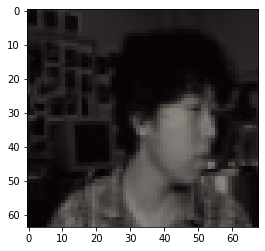

In [9]:
# Ejemplo de predicción correcta para foto de persona sin gafas
img, label = test_set[10]
model.to('cpu')
out = model(torch.unsqueeze(img, 0))
_, index = torch.max(out, dim = 1)

print('correct: ', class_names[label], 'model: ', class_names[index])
imshow(img)

correct:  Sunglasses model:  Sunglasses


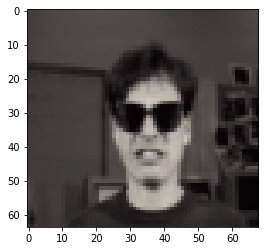

In [10]:
# Ejemplo de predicción correcta para foto de persona con gafas
img, label = test_set[450]
model.to('cpu')
out = model(torch.unsqueeze(img, 0))
_, index = torch.max(out, dim = 1)

print('correct: ', class_names[label], 'model: ', class_names[index])
imshow(img)